## Задача

Сгенерировать последовательности, которые состоят из цифр (от 0 до 9) и задаются следующим образом:

x - последовательность цифр,
y1 = x1,
yi = xi + x1, если yi >= 10, то yi = yi - 10.

Научить модель рекуррентной нейронной сети предсказывать yi по xi. Использовать: RNN, LSTM, GRU

## Решение

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt

### 1. Генерация последовательностей х и y

Зададим генераторы случайных чисел и тензоров

In [2]:
rng = np.random.default_rng(seed=111)
torch.manual_seed(111)

Зададим максимальную длину последовательности и количество последовательностей в одном наборе данных

In [3]:
# Максимальная длина последовательности х
X_MAX_LENGTH = 12

# Количество последовательностей х в рамках одного обучающего датасета
N_SEQUENCES = 190

# Количество предсказываемых классов, т.е. числа от 0 до 9
NUM_CLASSES = 10

Создадим класс SequenceGenerator, который генерирует последовательности значений х и последовательности значений y, а также соответствующие тензоры на их основе. Данный класс принимает на вход значения максимальной длины последовательности и количество последовательности в наборе данных.

In [4]:
class SequenceGenerator(nn.Module):
    """
    Класс для генерации последовательностей x и соответствующих преобразованных последовательностей y.

    Атрибуты
    --------
    x_max_length : int
        Максимальная длина последовательности x.
    n_sequences : int
        Количество генерируемых последовательностей y.

    Методы
    ------
    generate_x_sequences()
        Генерирует список последовательностей случайных цифр (последовательности x).
    
    generate_y_sequences(x_sequences: np.ndarray) -> np.ndarray
        Генерирует последовательности y на основе правил преобразования для x.
    
    generate_tensors(x_sequences: np.ndarray, y_sequences: np.ndarray) -> tuple
        Преобразует сгенерированные последовательности x и y в тензоры PyTorch.
    """

    def __init__(self, x_max_length: int, n_sequences: int):
        """
        Инициализирует атрибуты для объекта SequenceGenerator.

        Параметры
        ---------
        x_max_length : int
            Максимальная длина последовательности x.
        n_sequences : int
            Количество генерируемых последовательностей.
        """
        super().__init__()
        self.x_max_length = x_max_length
        self.n_sequences = n_sequences

    def generate_x_sequences(self) -> np.ndarray:
        """
        Генерирует список случайных последовательностей цифр x.

        Возвращает
        ----------
        np.ndarray
            Массив сгенерированных последовательностей случайных цифр x.
        """
        return rng.integers(0, 10, size=(self.n_sequences, self.x_max_length))
    
    def generate_y_sequences(self, x_sequences: np.ndarray) -> np.ndarray:
        """
        Генерирует последовательности y на основе правил преобразования, заданных для x.

        Параметры
        ---------
        x_sequences : np.ndarray
            Массив последовательностей случайно сгенерированных цифр.

        Возвращает
        ----------
        np.ndarray
            Массив преобразованных последовательностей y.
        """
        y_sequences = []
        for n in x_sequences:
            y = [
                n[i] if i == 0 else (n[i] + n[0] - 10) if (i != 0 and (n[i] + n[0]) >= 10) else n[i] + n[0] 
                for i in range(len(n))
            ]
            y_sequences.append(y)

        return np.array(y_sequences)
    
    def generate_tensors(self, x_sequences: np.ndarray, y_sequences: np.ndarray) -> tuple:
        """
        Преобразует сгенерированные последовательности x и y в тензоры PyTorch.

        Параметры
        ---------
        x_sequences : np.ndarray
            Массив последовательностей случайно сгенерированных цифр.
        y_sequences : np.ndarray
            Массив преобразованных последовательностей y.

        Возвращает
        ----------
        tuple
            Кортеж, содержащий два LongTensor PyTorch: один для x_sequences и один для y_sequences.
        """
        x_tensor = torch.LongTensor(x_sequences)
        y_tensor = torch.LongTensor(y_sequences)

        return x_tensor, y_tensor

In [5]:
sequence_generator = SequenceGenerator(X_MAX_LENGTH, N_SEQUENCES)

Сгенерируем последовательности х и y, используя экземпляр класса Sequence_Generator, которые затем преобразуем в тензоры.

In [6]:
x_sequences = sequence_generator.generate_x_sequences()
y_sequences = sequence_generator.generate_y_sequences(x_sequences)

In [7]:
x_sequences, y_sequences

(array([[4, 1, 7, ..., 7, 7, 1],
        [1, 7, 4, ..., 3, 0, 7],
        [7, 0, 9, ..., 3, 5, 6],
        ...,
        [6, 7, 2, ..., 3, 7, 5],
        [8, 4, 1, ..., 6, 0, 2],
        [5, 9, 3, ..., 5, 7, 4]], shape=(190, 12)),
 array([[4, 5, 1, ..., 1, 1, 5],
        [1, 8, 5, ..., 4, 1, 8],
        [7, 7, 6, ..., 0, 2, 3],
        ...,
        [6, 3, 8, ..., 9, 3, 1],
        [8, 2, 9, ..., 4, 8, 0],
        [5, 4, 8, ..., 0, 2, 9]], shape=(190, 12)))

In [8]:
x_train, y_train = sequence_generator.generate_tensors(x_sequences, y_sequences)
x_train, y_train

(tensor([[4, 1, 7,  ..., 7, 7, 1],
         [1, 7, 4,  ..., 3, 0, 7],
         [7, 0, 9,  ..., 3, 5, 6],
         ...,
         [6, 7, 2,  ..., 3, 7, 5],
         [8, 4, 1,  ..., 6, 0, 2],
         [5, 9, 3,  ..., 5, 7, 4]]),
 tensor([[4, 5, 1,  ..., 1, 1, 5],
         [1, 8, 5,  ..., 4, 1, 8],
         [7, 7, 6,  ..., 0, 2, 3],
         ...,
         [6, 3, 8,  ..., 9, 3, 1],
         [8, 2, 9,  ..., 4, 8, 0],
         [5, 4, 8,  ..., 0, 2, 9]]))

### 2. Создание модели рекуррентной нейронной сети

Создадим класс нейронной сети RnnFlex на основе nn.Module с рекуррентным слоем для предсказания классов, т.е. цифр от 0 до 9.

In [9]:
class RnnFlex(nn.Module):
    """
    Класс нейронной сети с рекуррентным слоем (RNN, LSTM, GRU) для предсказания классов.

    Атрибуты
    --------
    embedding : torch.nn.Embedding
        Преобразование входной последовательности в векторное пространство.
    hidden : torch.nn.RNN, torch.nn.LSTM, torch.nn.GRU
        Рекуррентный слой, который может быть любого класса (RNN, LSTM, GRU).
    relu : torch.nn.ReLU
        Слой ReLU активации.
    dropout : torch.nn.Dropout
        Слой Dropout для регуляризации.
    linear : torch.nn.Linear
        Полносвязный слой для преобразования скрытых состояний.
    output : torch.nn.Linear
        Полносвязный слой для предсказания классов.
    is_lstm : bool
        Флаг, указывающий, является ли рекуррентный слой LSTM.
    
    Методы
    ------
    forward(X)
        Выполняет прямой проход через сеть для предсказания выходов на основе входных данных X.
    """
    
    def __init__(self, rnn_class, sequence_length, embedding_size, num_hiddens, num_hiddens2, num_classes):
        """
        Инициализирует нейронную сеть с заданным рекуррентным слоем и архитектурой.

        Параметры
        ---------
        rnn_class : класс
            Класс рекуррентного слоя (torch.nn.RNN, torch.nn.LSTM или torch.nn.GRU).
        sequence_length : int
            Длина входной последовательности.
        embedding_size : int
            Размер векторного представления.
        num_hiddens : int
            Размер скрытого состояния рекуррентного слоя.
        num_hiddens2 : int
            Размер скрытого состояния полносвязного слоя.
        num_classes : int
            Количество классов на выходе (размерность выходного слоя). По умолчанию используется значение 10 (цифры от 0 до 9).
        """
        super().__init__()
        self.embedding = torch.nn.Embedding(sequence_length, embedding_size)
        self.hidden = rnn_class(embedding_size, num_hiddens, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear = torch.nn.Linear(num_hiddens, num_hiddens2)
        self.output = torch.nn.Linear(num_hiddens2, num_classes)
        self.is_lstm = issubclass(rnn_class, torch.nn.LSTM)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Выполняет прямой проход через нейронную сеть.

        Параметры
        ---------
        x : torch.Tensor
            Входной тензор с последовательностями х.

        Возвращает
        ----------
        torch.Tensor
            Предсказания последовательности y для каждой последовательности х в виде тензора.
        """
        out = self.embedding(x)
        if self.is_lstm:
            out, (state, _) = self.hidden(out)
        else:
            out, state = self.hidden(out)
        output = self.linear(self.dropout(self.relu(out)))
        predictions = self.output(self.dropout(self.relu(output)))
        return predictions

Инициализируем модель рекуррентной нейронной сети с заданными параметрами

In [10]:
def initialize_model(
        rnn_class=nn.LSTM, embedding_size=64, num_hiddens=256, num_hiddens2=32, num_classes=NUM_CLASSES, sequence_length=X_MAX_LENGTH, lr=0.001
        ):
    """
    Инициализирует модель с указанным рекуррентным слоем (RNN, LSTM или GRU), 
    функцией потерь и оптимизатором.

    Параметры
    ----------
    rnn_class : torch.nn.Module, optional
        Класс рекуррентного слоя, который может быть torch.nn.RNN, torch.nn.LSTM или torch.nn.GRU.
        По умолчанию используется torch.nn.LSTM.
    embedding_size : int, optional
        Размер векторного представления (embedding). По умолчанию 64.
    num_hiddens : int, optional
        Размер скрытого состояния для рекуррентного слоя. По умолчанию 256.
    num_hiddens2 : int, optional
        Размер скрытого состояния для второго полносвязного слоя. По умолчанию 32.
    num_classes : int, optional
        Количество классов для классификации. По умолчанию используется значение NUM_CLASSES.
    sequence_length : int, optional
        Длина входной последовательности. По умолчанию используется значение X_MAX_LENGTH.
    lr : float, optional
        Значение скорости обучения модели. По умолчанию используется значение 0,001.

    Возвращает
    ---------
    model : torch.nn.Module
        Инициализированная модель с выбранным рекуррентным слоем.
    criterion : torch.nn.Module
        Функция потерь (кросс-энтропия).
    optimizer : torch.optim.Optimizer
        Оптимизатор Adam.
    """
    # Инициализация модели с заданным рекуррентным слоем
    model = RnnFlex(
        rnn_class, sequence_length, embedding_size, num_hiddens, num_hiddens2, num_classes
    )

    # Функция потерь для задачи классификации
    criterion = nn.CrossEntropyLoss()

    # Оптимизатор Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, criterion, optimizer


Создадим функцию для обучения модели и определения среднего значения функции потерь

In [11]:
def train_loss(model, optimizer, criterion, x, y):
    """
    Выполняет одну эпоху обучения, вычисляя и обновляя веса модели на основе входных данных и целевых значений.

    Параметры
    ----------
    model : torch.nn.Module
        Модель, которая будет обучаться.
    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели.
    criterion : torch.nn.Module
        Функция потерь, используемая для вычисления ошибки.
    x : torch.Tensor
        Входные данные (последовательности х), используемые для обучения модели.
    y : torch.Tensor
        Целевые метки, которые сравнивают с предсказаниями модели (последовательности y).

    Возвращает
    ---------
    float
        Среднее значение функции потерь на всем обучающем наборе данных.
    """
    model.train()
    total_loss = 0

    for i, x_item in enumerate(x):
        optimizer.zero_grad()

        answers = model(x_item.unsqueeze(0))

        answers = answers.view(-1, NUM_CLASSES)
        target = y[i].view(-1)

        loss = criterion(answers, target)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(x)

Создадим функцию для контроля изменения функции потерь в зависимости от эпохи

In [12]:
def train_loss_control(model, optimizer, criterion, x, y, n_epochs=50):
    """
    Управляет процессом обучения модели, отслеживает значения функции потерь и выводит их график.

    Параметры
    ---------
    model : torch.nn.Module
        Модель, которая будет обучаться.
    optimizer : torch.optim.Optimizer
        Оптимизатор для обновления весов модели.
    criterion : torch.nn.Module
        Функция потерь для оптимизации.
    X : torch.Tensor
        Входные данные (последовательности x) для обучения.
    y : torch.Tensor
        Целевые метки (последовательности y) для обучения.
    n_epochs : int, optional
        Количество эпох обучения (по умолчанию 50).

    Возвращает
    ----------
    list
        Список значений функции потерь на каждой эпохе.
    """
    loss_values = []
    for epoch in range(n_epochs):
        start = time.time()
        train_loss_value = train_loss(model, optimizer, criterion, x, y)
        loss_values.append(train_loss_value)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}. Time: {time.time() - start:.3f}, Train loss: {train_loss_value:.3f}")

    plt.plot(loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss over Epochs: {model.hidden}")
    plt.show()

    return loss_values

Создадим функцию предсказания последовательности значений y и соответствующего значения y_i с учетом последовательности значений х и индекса значения x_i соответственно.

In [13]:
def y_inference(model, x_max_length, x_index=0):
    """
    Функция для предсказания последовательности y, а также конкретного значения y_i
    с помощью обученной модели.

    Эта функция генерирует входные последовательности и соответствующие целевые
    последовательности с использованием SequenceGenerator, затем делает предсказание
    с помощью модели и вычисляет точность.

    Параметры
    ----------
    model : torch.nn.Module
        Обученная модель для предсказания y.
    x_max_length : int
        Максимальная длина последовательности x.
    x_index : int, optional
        Индекс значения x в последовательности, которое необходимо предсказать.
        По умолчанию 0.

    Вывод
    ------
    None
        Функция выводит точность, входную последовательность x, целевую последовательность y,
        предсказанную последовательность predicted_sequence и значения y_i для индекса x_i.
    """
    sequence_generator = SequenceGenerator(x_max_length, n_sequences=1)
    x = torch.LongTensor(sequence_generator.generate_x_sequences())
    y = torch.LongTensor(sequence_generator.generate_y_sequences(x))

    model.eval()
    with torch.no_grad():
        output = model(x)

        predicted_sequence = []
        correct = 0
        total = len(x[0])

        for i in range(output.size(1)):
            predicted_value = output[0, i].argmax().item()
            predicted_sequence.append(predicted_value)

            correct += (predicted_value == y[0, i].item())
        accuracy = correct / total * 100

    x_value = x[0].tolist()[x_index]
    y_target = y[0].tolist()[x_index]
    y_predicted = predicted_sequence[x_index]

    df = pd.DataFrame({
        "Параметр": [
            "Accuracy (%)", 
            "Входная последовательность x", 
            "Целевая последовательность y", 
            "Предсказанная последовательность y", 
            "Заданное значение индекса x", 
            "Соответствующее значение x_i", 
            "Целевое значение y_i", 
            "Предсказанное значение y_i"
        ],
        "Значение": [
            round(accuracy, 2),
            x[0].tolist(),
            y[0].tolist(),
            predicted_sequence,
            x_index,
            x_value,
            y_target,
            y_predicted
        ]
    })
    
    pd.set_option('display.max_seq_item', None)
    pd.set_option('display.max_colwidth', None)

    return df

### 3. Обучение модели рекуррентной нейронной сети и предсказание значений

#### 3.1 Инициализация модели LSTM и ее обучение, а также предсказание значений для заданного значения максимальной длины последовательности и количества последовательности

In [14]:
model_lstm, criterion, optimizer = initialize_model(
    rnn_class=nn.LSTM,
    embedding_size=64,
    num_hiddens=256,
    num_hiddens2=32,
    num_classes=NUM_CLASSES,
    sequence_length=X_MAX_LENGTH
    )

Epoch 0. Time: 0.860, Train loss: 2.299
Epoch 10. Time: 0.794, Train loss: 0.204
Epoch 20. Time: 0.654, Train loss: 0.027
Epoch 30. Time: 0.651, Train loss: 0.016
Epoch 40. Time: 0.735, Train loss: 0.013


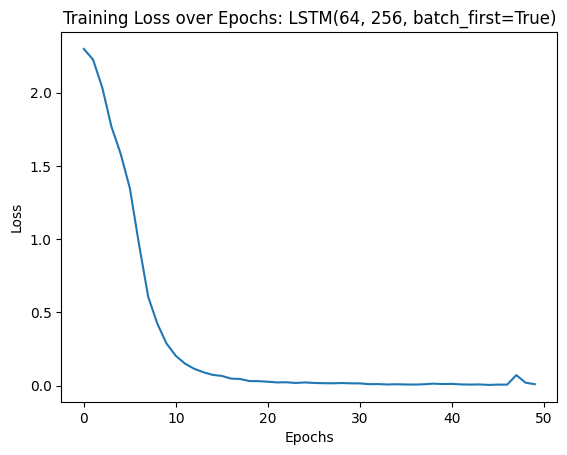

In [15]:
loss_values_lstm = train_loss_control(model_lstm, optimizer, criterion, x_train, y_train, n_epochs=50)

In [16]:
y_inference(model_lstm, x_max_length=25, x_index=5)

,Параметр,Значение
0,Accuracy (%),100.0
1,Входная последовательность x,"[7, 4, 7, 4, 1, 6, 3, 6, 5, 7, 8, 5, 6, 6, 9, 1, 0, 0, 4, 4, 9, 0, 1, 8, 7]"
2,Целевая последовательность y,"[7, 1, 4, 1, 8, 3, 0, 3, 2, 4, 5, 2, 3, 3, 6, 8, 7, 7, 1, 1, 6, 7, 8, 5, 4]"
3,Предсказанная последовательность y,"[7, 1, 4, 1, 8, 3, 0, 3, 2, 4, 5, 2, 3, 3, 6, 8, 7, 7, 1, 1, 6, 7, 8, 5, 4]"
4,Заданное значение индекса x,5
5,Соответствующее значение x_i,6
6,Целевое значение y_i,3
7,Предсказанное значение y_i,3


#### 3.2 Инициализация модели RNN и ее обучение, а также предсказание значений для заданного значения максимальной длины последовательности и количества последовательности

In [17]:
model_rnn, criterion, optimizer = initialize_model(
    rnn_class=nn.RNN,
    embedding_size=64,
    num_hiddens=256,
    num_hiddens2=32,
    num_classes=NUM_CLASSES,
    sequence_length=X_MAX_LENGTH,
    lr=0.0005
    )

Epoch 0. Time: 1.072, Train loss: 2.289
Epoch 10. Time: 0.697, Train loss: 1.583
Epoch 20. Time: 1.054, Train loss: 0.986
Epoch 30. Time: 0.747, Train loss: 0.451
Epoch 40. Time: 0.801, Train loss: 0.122


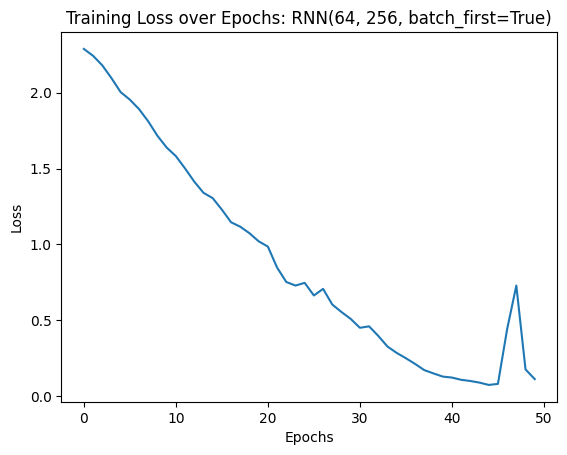

In [18]:
loss_values_rnn = train_loss_control(model_rnn, optimizer, criterion, x_train, y_train, n_epochs=50)

In [19]:
y_inference(model_rnn, x_max_length=25, x_index=5)

,Параметр,Значение
0,Accuracy (%),100.0
1,Входная последовательность x,"[6, 7, 0, 0, 4, 3, 9, 0, 9, 2, 0, 7, 3, 2, 4, 2, 6, 5, 4, 1, 4, 9, 0, 9, 6]"
2,Целевая последовательность y,"[6, 3, 6, 6, 0, 9, 5, 6, 5, 8, 6, 3, 9, 8, 0, 8, 2, 1, 0, 7, 0, 5, 6, 5, 2]"
3,Предсказанная последовательность y,"[6, 3, 6, 6, 0, 9, 5, 6, 5, 8, 6, 3, 9, 8, 0, 8, 2, 1, 0, 7, 0, 5, 6, 5, 2]"
4,Заданное значение индекса x,5
5,Соответствующее значение x_i,3
6,Целевое значение y_i,9
7,Предсказанное значение y_i,9


#### 3.3 Инициализация модели GRU и ее обучение, а также предсказание значений для заданного значения максимальной длины последовательности и количества последовательности

In [20]:
model_gru, criterion, optimizer = initialize_model(
    rnn_class=nn.GRU,
    embedding_size=64,
    num_hiddens=256,
    num_hiddens2=32,
    num_classes=NUM_CLASSES,
    sequence_length=X_MAX_LENGTH,
    lr=0.001
    )

Epoch 0. Time: 2.208, Train loss: 2.295
Epoch 10. Time: 1.762, Train loss: 0.311
Epoch 20. Time: 1.333, Train loss: 0.098
Epoch 30. Time: 1.276, Train loss: 0.046
Epoch 40. Time: 1.498, Train loss: 0.039


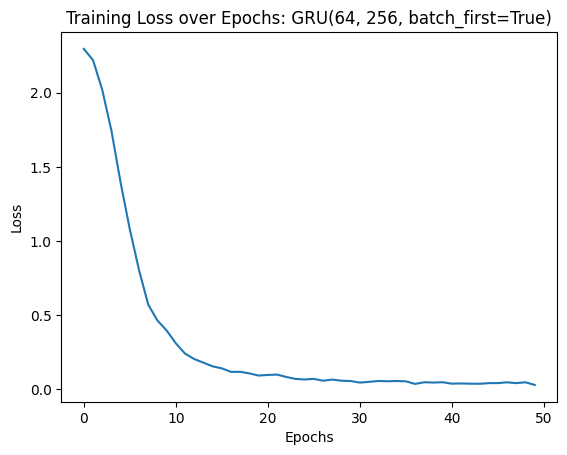

In [21]:
loss_values_gru = train_loss_control(model_gru, optimizer, criterion, x_train, y_train, n_epochs=50)

In [22]:
y_inference(model_gru, x_max_length=25, x_index=5)

,Параметр,Значение
0,Accuracy (%),100.0
1,Входная последовательность x,"[0, 0, 2, 3, 0, 2, 6, 8, 8, 5, 9, 4, 6, 3, 5, 5, 2, 2, 6, 8, 5, 4, 6, 0, 3]"
2,Целевая последовательность y,"[0, 0, 2, 3, 0, 2, 6, 8, 8, 5, 9, 4, 6, 3, 5, 5, 2, 2, 6, 8, 5, 4, 6, 0, 3]"
3,Предсказанная последовательность y,"[0, 0, 2, 3, 0, 2, 6, 8, 8, 5, 9, 4, 6, 3, 5, 5, 2, 2, 6, 8, 5, 4, 6, 0, 3]"
4,Заданное значение индекса x,5
5,Соответствующее значение x_i,2
6,Целевое значение y_i,2
7,Предсказанное значение y_i,2


### Заключение

Проведение обучение и предсказание значений с помощью моделей рекуррентной нейронной сети (RNN, LSTM, GRU). Модели LSTM и GRU показали наилучшие результаты; эти модели демонстрировали 100 % точность при любых значениях параметрах. Это свидетельствует о том, что данные модели легко находили решение задачи. Модель RNN, несмотря на то, что она позволила добиться 100 % точности, требовала тщательного подбора параметров (скорость обучения, размера вектора эмбеддингов, число узлов в рекуррентной нейронной сети), а также скрытых слоев.